## XGBoost Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb

In [3]:
train_path = '../../feature_extracted_data/training_features_01.csv'
train_data = pd.read_csv(train_path)
train_label_path = '../../extracted_data/train_labels_full_with_columns.csv'
train_labels = pd.read_csv(train_label_path)

In [7]:
test_data = pd.read_csv("../../feature_extracted_data/test_features_01.csv")
test_labels = pd.read_csv("../../extracted_data/test_labels_full_with_columns.csv")

### Combine with original data & feature extracted

In [9]:
original_train_data = pd.read_csv("../../extracted_data/training_data_full_with_columns.csv")
original_test_data = pd.read_csv("../../extracted_data/test_data_full_with_columns.csv")
merged_train_df = pd.concat([original_train_data, train_data], axis=1)
merged_test_df = pd.concat([original_test_data, test_data], axis=1)

In [10]:
# Separate features and target
X_train = merged_train_df
y_train = train_labels['MM263']

X_test = merged_test_df
y_test = test_labels['MM263']

In [11]:
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, balanced_accuracy_score

def xgBoostModel(X_train, y_train):
    # Initialize the label encoder
    le = LabelEncoder()

    # Fit label encoder and return encoded labels
    y_train_encoded = le.fit_transform(y_train)

    # Initialize the XGBoost classifier
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Train the model with the encoded labels
    model.fit(X_train, y_train_encoded)

    # Store the label encoder in the model object for future use (prediction phase)
    model.label_encoder_ = le

    return model


In [12]:
# Train the model
model = xgBoostModel(X_train, y_train)

# Assume y_test is available and needs to be encoded using the same encoder used for y_train
y_test_encoded = model.label_encoder_.transform(y_test)

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]  # Probabilities for the positive class

# Compute ROC AUC
auc = roc_auc_score(y_test_encoded, y_pred_proba)
print(f"ROC AUC: {auc}")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:49:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC: 0.9021513405044683


In [18]:
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

for thresh in thresholds:
    y_pred_thresholded = np.where(y_pred_proba >= thresh, 1, 0)
    # accuracy = accuracy_score(y_test_encoded, y_pred_thresholded)
    print(f"Threshold: {thresh}")
    balanced_acc = balanced_accuracy_score(y_test_encoded, y_pred_thresholded)
    print(f"Balanced Accuracy: {balanced_acc}")
    
    print("Classification Report:")
    print(classification_report(y_test_encoded, y_pred_thresholded))

    cm = confusion_matrix(y_test_encoded, y_pred_thresholded)
    cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100  # Normalizing the confusion matrix to get percentages
    print("Confusion Matrix:\n", cm)
    print("Confusion Matrix (%):\n", np.round(cm_percentage, 2))  # Printing the percentage matrix rounded to 2 decimal places

    print("\n")


Threshold: 0.01
Balanced Accuracy: 0.6461663205544018
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5042
           1       0.53      0.29      0.38        34

    accuracy                           0.99      5076
   macro avg       0.76      0.65      0.69      5076
weighted avg       0.99      0.99      0.99      5076

Confusion Matrix:
 [[5033    9]
 [  24   10]]
Confusion Matrix (%):
 [[99.82  0.18]
 [70.59 29.41]]


Threshold: 0.05
Balanced Accuracy: 0.5587243624145414
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5042
           1       0.80      0.12      0.21        34

    accuracy                           0.99      5076
   macro avg       0.90      0.56      0.60      5076
weighted avg       0.99      0.99      0.99      5076

Confusion Matrix:
 [[5041    1]
 [  30    4]]
Confusion Matrix (%):
 [[9.998e+01 2.000e-02

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Feature Importance

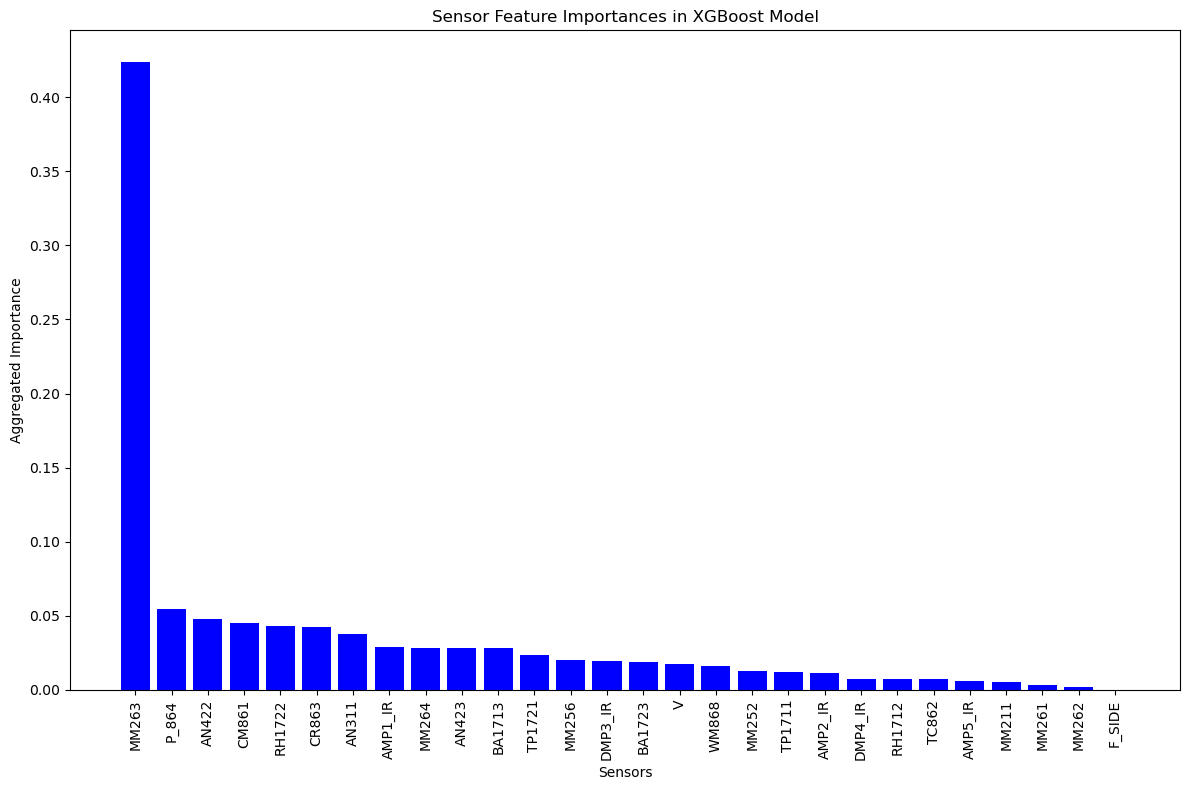

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances from the model
importances = model.feature_importances_
feature_names = X_train.columns  # Ensure your feature data has column names

# Create a DataFrame from features and their importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# List of all sensor names
sensors = [
    "AN311", "AN422", "AN423", "TP1721", "RH1722", "BA1723", "TP1711", "RH1712", "BA1713",
    "MM252", "MM261", "MM262", "MM263", "MM264", "MM256", "MM211", "CM861", "CR863", "P_864",
    "TC862", "WM868", "AMP1_IR", "AMP2_IR", "DMP3_IR", "DMP4_IR", "AMP5_IR", "F_SIDE", "V"
]

# Function to extract the base sensor name
def extract_sensor_name(feature_name):
    for sensor in sensors:
        if feature_name.startswith(sensor):
            return sensor
    return "Unknown Sensor"

# Apply the function to get sensor names
importance_df['Sensor'] = importance_df['Feature'].apply(extract_sensor_name)

# Initialize a DataFrame with zeros for all sensors
sensor_importances = pd.DataFrame({'Sensor': sensors, 'Importance': [0.0]*len(sensors)})

# Aggregate importances by sensor and sum them
aggregated_importances = importance_df.groupby('Sensor').Importance.sum().reset_index()

# Update the initialized DataFrame with the computed importances
sensor_importances.set_index('Sensor', inplace=True)
sensor_importances.update(aggregated_importances.set_index('Sensor'))
sensor_importances.reset_index(inplace=True)

# Sort the sensors by their importance
sorted_sensor_importances = sensor_importances.sort_values(by='Importance', ascending=False)

# Print the sorted sensor importances
# print(sorted_sensor_importances)

# Plot the sensor importances
plt.figure(figsize=(12, 8))
plt.bar(sorted_sensor_importances['Sensor'], sorted_sensor_importances['Importance'], color='b')
plt.xlabel('Sensors')
plt.ylabel('Aggregated Importance')
plt.title('Sensor Feature Importances in XGBoost Model')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Model without cutter loader features

In [21]:
import pandas as pd

prefixes_to_remove = ['AMP1_IR', 'AMP2_IR', 'DMP3_IR', 'DMP4_IR', 'AMP5_IR', 'F_SIDE', 'V']

# Generate a list of columns to drop
columns_to_drop = [col for col in X_train.columns if any(col.startswith(prefix) for prefix in prefixes_to_remove)]

# Drop these columns from the DataFrame
X_train_new = X_train.drop(columns=columns_to_drop)
X_test_new = X_test.drop(columns=columns_to_drop)


In [22]:
# Train the model
model = xgBoostModel(X_train_new, y_train)

# Assume y_test is available and needs to be encoded using the same encoder used for y_train
y_test_encoded = model.label_encoder_.transform(y_test)

# Predict on the test data
y_pred = model.predict(X_test_new)
y_pred_proba = model.predict_proba(X_test_new)[:,1]  # Probabilities for the positive class

# Compute ROC AUC
auc = roc_auc_score(y_test_encoded, y_pred_proba)
print(f"ROC AUC: {auc}")

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC: 0.8947779825932753


In [23]:
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

for thresh in thresholds:
    y_pred_thresholded = np.where(y_pred_proba >= thresh, 1, 0)
    # accuracy = accuracy_score(y_test_encoded, y_pred_thresholded)
    print(f"Threshold: {thresh}")
    balanced_acc = balanced_accuracy_score(y_test_encoded, y_pred_thresholded)
    print(f"Balanced Accuracy: {balanced_acc}")
    
    print("Classification Report:")
    print(classification_report(y_test_encoded, y_pred_thresholded))

    cm = confusion_matrix(y_test_encoded, y_pred_thresholded)
    cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100  # Normalizing the confusion matrix to get percentages
    print("Confusion Matrix:\n", cm)
    print("Confusion Matrix (%):\n", np.round(cm_percentage, 2))  # Printing the percentage matrix rounded to 2 decimal places

    print("\n")

Threshold: 0.01
Balanced Accuracy: 0.5718435728119093
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5042
           1       0.23      0.15      0.18        34

    accuracy                           0.99      5076
   macro avg       0.61      0.57      0.59      5076
weighted avg       0.99      0.99      0.99      5076

Confusion Matrix:
 [[5025   17]
 [  29    5]]
Confusion Matrix (%):
 [[99.66  0.34]
 [85.29 14.71]]


Threshold: 0.05
Balanced Accuracy: 0.5147058823529411
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5042
           1       1.00      0.03      0.06        34

    accuracy                           0.99      5076
   macro avg       1.00      0.51      0.53      5076
weighted avg       0.99      0.99      0.99      5076

Confusion Matrix:
 [[5042    0]
 [  33    1]]
Confusion Matrix (%):
 [[100.     0.  ]
 [ 9

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa